# Character Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from ocr import page, words
from ocr.normalization import imageNorm, letterNorm
from ocr.tfhelpers import Graph
# Helper functions - ploting and resizing
from ocr.helpers import implt, resize

plt.rcParams['figure.figsize'] = (15.0, 9.0)


print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.3.0


### Gloval Variables

In [2]:
IMG = "text"

## Load Image and Separate Words

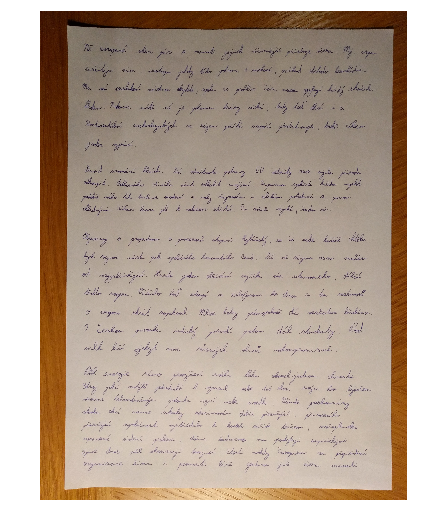

In [3]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

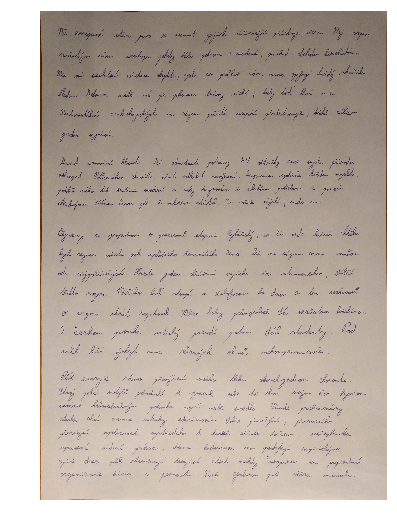

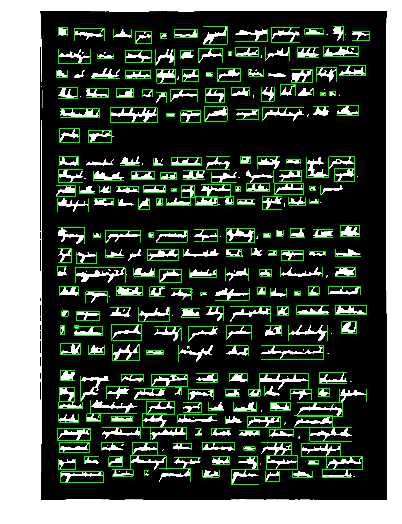

In [4]:
# Crop image and get bounding boxes of words
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Load Trained Model

In [5]:
gapClass = Graph('models/gap-clas/CNN-CG')
print("Successfully loaded.")

INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG
Successfully loaded.


## Applying Model

In [13]:
class Cycler:
    """ Cycle through boxes, separate words """
    width = 30
    height = 60
    step = 2
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.pos = 0             # Position po slider
        self.actual = image      # Current image of word, drawing lines
        self.actualG = image     # Current slider image, evaluating
        self.nextImg(boxes)
    
    def nextPos(self):
        """ Sliding over image and classifying regions """      
        
        # Getting Array of Sep Lines
        gaps = []
        isPrevGap = True
        gapPositionSum = self.pos + self.width/2
        first = True
        gapBlockFirst = 0
        gapBlockLast = self.pos + self.width/2
        gapCount = 1
        separate = False
        gapsImage = self.actual.copy()
        
        while self.pos < len(self.actual[0]) - self.width:
            # Go through all regions
            
            # Get the region
            img = self.actualG[0:self.height, self.pos:self.pos + self.width]
            
            # Pixel transform and rescale the image
            data = np.reshape(img, (1, 1800)).astype(np.float32)
            
            # Using model for prediction
            if gapClass.run(data) == 1:
                # If is GAP - add possition to sum
                gapPositionSum += self.pos + self.width/2
                gapBlockLast = self.pos + self.width/2
                if gapBlockFirst == 0:
                    gapBlockFirst = self.pos + self.width/2
                gapCount += 1
                isPrevGap = True
                separate = False
                
                # Plotting all lines
                cv2.line(self.actual,
                         ((int)(self.pos + self.width/2),0),
                         ((int)(self.pos + self.width/2),
                         self.height), (0,255,0), 1)
            else:
                # Add gap position into array 
                # only if two successive letter lines detected
                if not separate and isPrevGap:
                    separate = True
                elif separate:
                    if first:
                        gaps.append(gapBlockLast)
                        gapPositionSum = 0
                        gapCount = 0
                        separate = False
                        first = False
                    else:
                        gaps.append(gapPositionSum / gapCount)
                        gapPositionSum = 0
                        gapCount = 0
                        separate = False
                gapBlockFirst = 0    
                isPrevGap = False
                
                # Plotting all lines
                cv2.line(self.actual,
                         ((int)(self.pos + self.width/2),0),
                         ((int)(self.pos + self.width/2),
                         self.height), (255,0,0), 1)    
            
            self.pos += self.step           
        
        # Adding final gap position
        if gapBlockFirst != 0:
            gaps.append(gapBlockFirst)
        else:
            gapPositionSum += self.pos + self.width/2
            gaps.append(gapPositionSum / (gapCount + 1))
        
        implt(self.actual)
        
        print("GAPS")
        for gap in gaps:
            cv2.line(gapsImage,
                     ((int)(gap),0),
                     ((int)(gap),
                     self.height), (0,255,0,0.5), 1)
        
        print(gaps)
        implt(gapsImage)
            

    def nextImg(self, b):
        """ Getting next image from the array """
        clear_output()
        
        self.pos = 0
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)                      
            implt(img, t='Original')
            img = imageNorm(img, self.height)
            
            self.actual = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            self.actualG = img         
            
            self.nextPos()
            
            # Printing index for recovery
            print("Index: " + str(self.index))
            
            # Create button for cycling through images
            bNexi = widgets.Button(description="Next Image")
            bNexi.on_click(self.nextImg)
            display(bNexi)
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

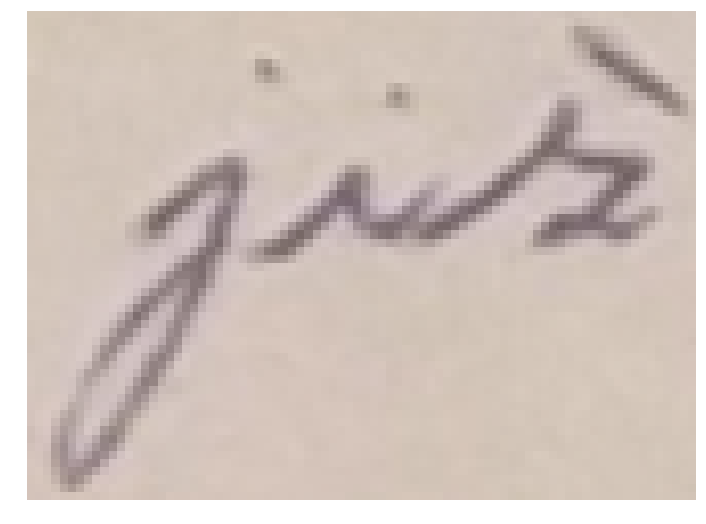

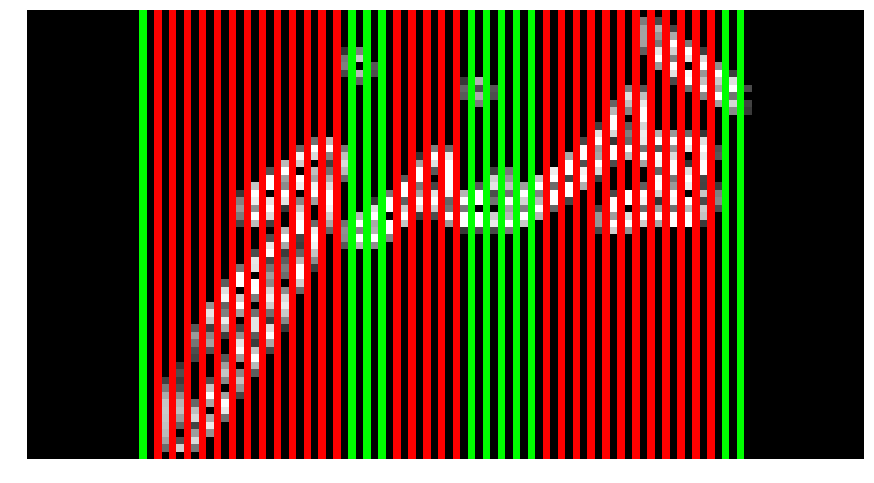

GAPS
[15.0, 45.0, 63.0, 93.0]


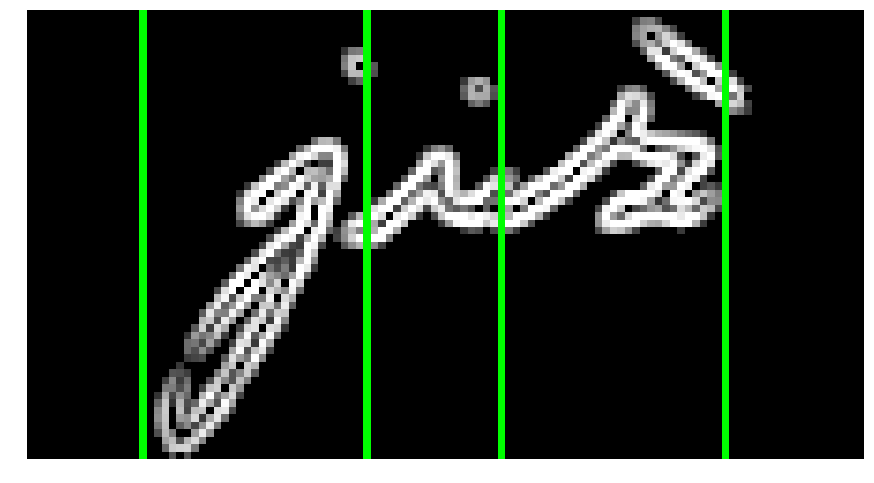

Index: 2


Button(description='Next Image', style=ButtonStyle())

In [15]:
# Class cycling through text positions
# Green - Characters
# Red   - Gaps
LAST_INDEX = 0
cycler = Cycler(crop, bBoxes, LAST_INDEX)